# Growth models: COVID-19
**Disclaimer**.  I am not an epidemiologist and this highly-simplified notebook is designed as an introduction to understanding modelling using python, rather than as a public health analysis. 

## Exponential growth

Consider a population containing $N$ items, e.g. atoms, people, or sick people. Each individual item experiences creation and later destruction. The change in size of the population ($dN$) depends on a growth factor (probablility per unit time, $k$) that describes the net effect of an individual reproducing (increases population) or dying (reduces population), multiplied by the current size of the population ($N$), multiplied by the length of time elapsed ($dt$). 

\begin{equation*}
dN = k N dt 
\end{equation*}


\begin{equation*}
\frac{dN}{dt} = k N  
\end{equation*}

or equivalently in dimensionless form

\begin{equation*}
\frac{dN}{N} = \frac{dt}{T}
\end{equation*}

where $T=1/k$ is a characteristic time.

If $k$ (and $T$ ) is not a function of $N$ then the equation can be easily separated, rearranged and integrated to find a solution.

\begin{equation*}
\int \frac{dN}{N} = \int k dt
\end{equation*}

If $k$ is constant (does not change with time), then the solution is

\begin{equation*}
\ln N = k t + A
\end{equation*}

\begin{equation*}
N = B \exp(k t) = B \exp\left(\frac{t}{T}\right)
\end{equation*}

i.e. exponential growth or decay, depending on the sign of the growth factor $k$ ($A$ and $B$ are constants, with $B = e^A$).

This equation describes some simple situations very well, e.g. radioactivity, but there are many situations that are more complicated. $k$ may be a function of $t$ or/and $N$, and those functions may not be easy to describe or separate/integrate. However, it may still be easy to use a **finite difference** method to find the solution. In simple terms, this means adding up discrete arrays, rather than generating an analytical solution. To illustrate this, lets create a simple example using numpy arrays and compare a finite difference solution with an analytical one. Try varying the value of `nSteps` and observe the accuracy change.


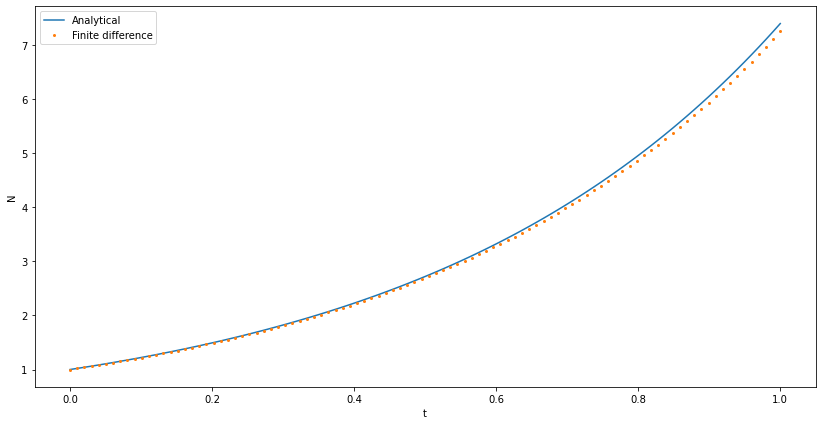

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nSteps = 100

k = 2
B = 1

t = np.linspace(0,1,nSteps)
dt = t[1]-t[0]

Nanalytical = B * np.exp(k * t)

''' Explicit (time-forward) finite difference solution'''
# Instantiate an array for N with every element having value=B
N = np.ones_like(t) * B

# use a loop to add each dN to find new values of N
for i in range(1,len(t)):
    dN = k * N[i-1] * dt
    N[i] = N[i-1] + dN

plt.figure(figsize=[14,7])
plt.plot(t,Nanalytical, label='Analytical')
plt.plot(t, N, marker='o', markersize=2, linewidth=0, label='Finite difference')
plt.xlabel('t')
plt.ylabel('N')
plt.legend()
plt.show()

Let's revisit our difference equation in the context of COVID-19

$dN = $ (new infections) $-$ (recoveries and deaths) $= I - D$

We have an estimate of infections per day (test results, but note issues with varying lags between infection and test). If we are to analyse COVID-19 we need a function that tells us how long people are infected for. Below is a candidate function that is broadly consistent with what has been reported (there remain large unknowns, it is likely not the best contender, but will do for now).

To see the effect of this, let's create a 70 day test dataset with a single spike of 1000 infections on day 10.

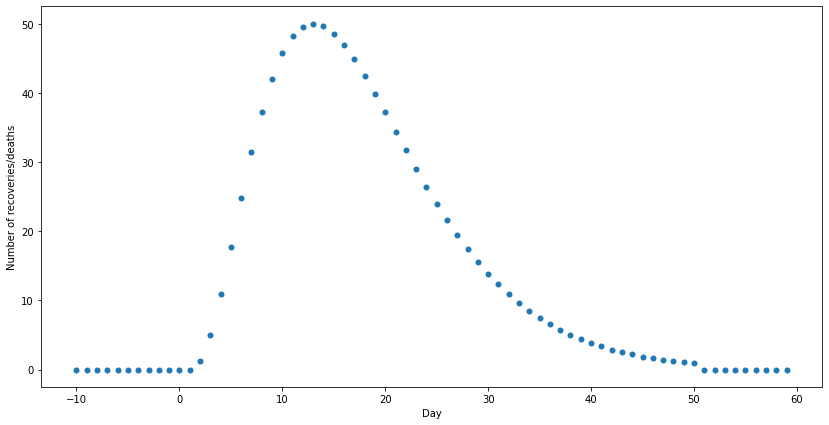

In [2]:
from scipy.stats import gamma
from scipy.signal import convolve

def covidRecoveries(infections):
    '''
    Generate distribution of total recoveries and deaths from daily infections.
    The procedure uses a gamma function with about the right shape to produce 
    a peak in recoveries at 10-14 days, and a tail of sustained infections 
    out to 50 days.

    Parameters
    ----------
    infections : numpy array
        Daily infection data. Single value for each day.

    Returns
    -------
    recoveries : numpy array
        Corresponding number of daily recoveries.

    '''
    halfWindow = 25
    t = np.arange(0,2*halfWindow)
    gammaFunc = gamma(3.4).pdf(t/5) # vary to get different shape
    recoveryTimePDF = gammaFunc / gammaFunc.sum()
    infectionsPadded = np.pad(infections,(halfWindow,0),'constant')
    recoveriesPadded = convolve(infectionsPadded,recoveryTimePDF,mode='same')
    recoveriesPadded = np.roll(recoveriesPadded,halfWindow)
    return recoveriesPadded[halfWindow:]

day = np.arange(-10,60)

infections = np.zeros_like(day)
infections[10] = 1000

recoveries = covidRecoveries(infections)

plt.figure(figsize=[14,7])
plt.plot(day, recoveries, marker='o', markersize=5, linewidth=0)
plt.xlabel('Day')
plt.ylabel('Number of recoveries/deaths')
plt.show()

Now that we have infection data (test results) and a function to predict when infections end, we can compute $N$ and hence estimate the growth factor $k$ during infection waves in our selected countries. We have daily data, so writing $dt=1$ and rearranging our first difference equation we have

\begin{equation*}
k = \frac{dN}{N} 
\end{equation*}

Each curve has been shifted so that it is aligned (day 0) at the first day that meets the criterion 

\begin{equation*}
N > \frac{N_{max}}{4}
\end{equation*}

C:\Users\sutherru\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


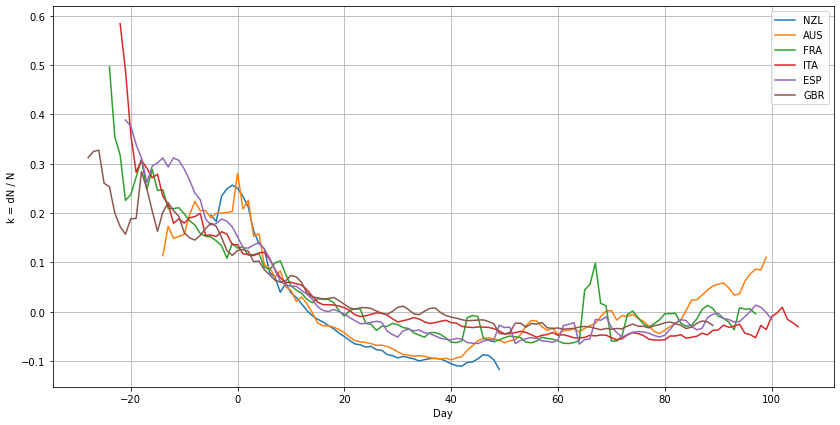

In [3]:
dataDir = '../DATA/covid/'
countryList = ['NZL','AUS','FRA','ITA','ESP','GBR']

plt.figure(figsize=[14,7])

for name in countryList:
    
    filename = dataDir + 'covid19_dailyCases_3dayAv_' + name + '.csv'   
    
    day,infections = np.loadtxt(filename, delimiter=',', skiprows=1,
                                usecols=(0,1), unpack=True)
     
    recoveries = covidRecoveries(infections)
    dN = infections - recoveries
    N  = np.cumsum(dN)
    # Note that this may give a warning: division by zero
    k  = dN / N
    
    selection = (N > 50)
    dayShifted = day - day[np.where(N >= N.max()/4)[0][0]]    
    plt.plot(dayShifted[selection],k[selection],label=name)

plt.grid(True)
plt.xlabel('Day')
plt.ylabel('k = dN / N')
plt.legend()
plt.show()


We see there is a distinct similarity to each curve, which reflects changes in human behaviour and hence transmission. 

To examine this in more detail, we can express new infections in the form 
\begin{equation*}
I = R_t N \frac{dt}{\tau}
\end{equation*}

\begin{equation*}
R_t = \frac{\tau I}{N dt}
\end{equation*}

where $\tau$ is the expected time of infection (taken as 14 days) and $R_t$ is the "reproduction number" i.e. the amount of new infections that each infected person generates. If $R_t < 1$, then $N$ will decrease with time.

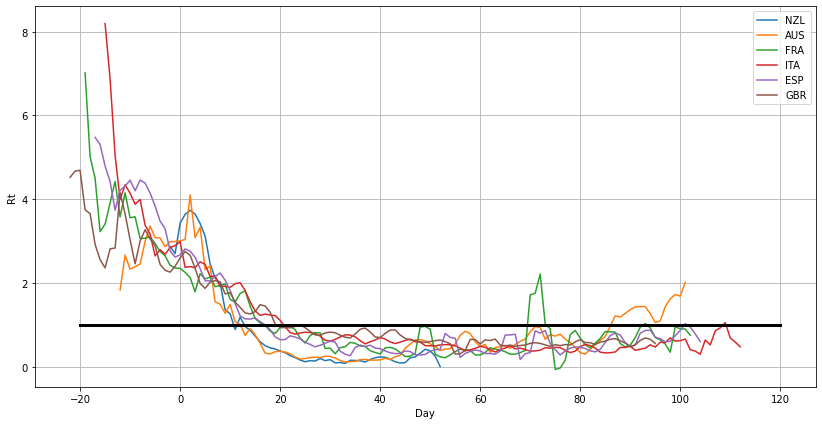

In [4]:
tau = 14

plt.figure(figsize=[14,7])

for name in countryList:
    
    filename = dataDir + 'covid19_dailyCases_3dayAv_' + name + '.csv'   
    
    day,infections = np.loadtxt(filename, delimiter=',', skiprows=1,
                                usecols=(0,1), unpack=True)
     
    recoveries = covidRecoveries(infections)
    dN = infections - recoveries
    N  = np.cumsum(dN)
    Rt = np.divide(tau*infections, N, where=(N>0)) # avoid division by zero
    
    selection = (N > 50)
    dayShifted = day - day[np.where(infections >= infections.max()/4)[0][0]]    
    plt.plot(dayShifted[selection],Rt[selection],label=name)

plt.grid(True)
plt.plot([-20,120],[1,1],linewidth=3,color='black')
plt.xlabel('Day')
plt.ylabel('Rt')
plt.legend()
plt.show()


Note that $R_t$ values drop more quickly than $k$ values, because there is a lag associated with lifespan of the infection. The $R_t$ value has more direct relevance to understanding effectiveness of public health measures.

_______________________________________________________________________
For further information about COVID-19 modelling:

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

https://www.nature.com/articles/d41586-020-02009-w

https://www.nature.com/articles/s41591-020-0822-7

https://jamanetwork.com/journals/jama/fullarticle/2765665

https://www.datacamp.com/community/tutorials/replicating-in-r-covid19

https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
